In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures



C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2005]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [8]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [9]:
rcParams['figure.figsize'] = 9, 6

# Rolling average window setting
window_setting= 20


LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

df['lag1'] = df.lag0.shift(periods=10)
df['lag2'] = df.lag0.shift(periods=20)
df['lag3'] = df.lag0.shift(periods=30)
df['lag4'] = df.lag0.shift(periods=40)
df['lag5'] = df.lag0.shift(periods=50)

df['lag6'] = df.lag0.shift(periods=60)
df['lag7'] = df.lag0.shift(periods=70)
df['lag8'] = df.lag0.shift(periods=80)
df['lag9'] = df.lag0.shift(periods=90)
df['lag10'] = df.lag0.shift(periods=100)

df.index = df['ds']
df = df.iloc[:, 1:]

df = df.dropna()

df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

lag0    lag1    lag2     lag3    lag4    lag5    lag6    lag7  \
ds                                                                             
2005-06-20  -297.50  105.75  -38.75  1006.15  199.00  118.85 -180.90  132.85   
2005-06-21  -740.25 -615.50  123.00  1473.65   23.50 -542.65 -388.90  259.85   
2005-06-22 -1031.00 -765.25  237.25  1238.15  -75.00 -828.15 -204.65  259.50   
2005-06-23 -1667.25 -446.25  234.50  1458.65  120.00 -529.40   56.85   51.00   
2005-06-24 -1890.75 -533.50   -6.00  1015.25  474.25  -85.50 -251.40  514.90   

               lag8     lag9   lag10        y  
ds                                             
2005-06-20  1102.30   619.90  -12.25 -1325.50  
2005-06-21   429.40  1019.25    3.25  -211.00  
2005-06-22   195.50   734.95   29.95  -633.50  
2005-06-23   827.35   566.60  203.50  -813.75  
2005-06-24   764.10   905.85  -88.75    98.75

## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [5]:
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc['2017-10-14':,:]
y_test = y['2017-10-14':]

X_train = X.loc[:'2017-10-14', :]
y_train = y[:'2017-10-14']


X_train.head()

lag0    lag1    lag2     lag3    lag4    lag5    lag6    lag7  \
ds                                                                             
2005-06-20  -297.50  105.75  -38.75  1006.15  199.00  118.85 -180.90  132.85   
2005-06-21  -740.25 -615.50  123.00  1473.65   23.50 -542.65 -388.90  259.85   
2005-06-22 -1031.00 -765.25  237.25  1238.15  -75.00 -828.15 -204.65  259.50   
2005-06-23 -1667.25 -446.25  234.50  1458.65  120.00 -529.40   56.85   51.00   
2005-06-24 -1890.75 -533.50   -6.00  1015.25  474.25  -85.50 -251.40  514.90   

               lag8     lag9   lag10  
ds                                    
2005-06-20  1102.30   619.90  -12.25  
2005-06-21   429.40  1019.25    3.25  
2005-06-22   195.50   734.95   29.95  
2005-06-23   827.35   566.60  203.50  
2005-06-24   764.10   905.85  -88.75

In [47]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


In [25]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index


# y_pred = y_pred.reindex(X_test.index)

[ 0.00067771 -0.05237931 -0.04851581  0.03964134 -0.07170782 -0.02895992
  0.01523419  0.0327573   0.01613883 -0.01529243 -0.05888668]


## Back to Scale before Performance Analysis

In [10]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = []
for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))
    unscaled.append(unscaled_result)

unscaled = pd.Series(unscaled)
unscaled = unscaled
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]



for key, item in y_pred_train.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

y_train_unscaled = pd.Series(original_tail)
y_train_unscaled = y_train_unscaled[window_setting:]
y_train_unscaled.index = y_train.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
original_y.head()



NameError: name 'y_pred' is not defined

In [11]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

In [27]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = []
for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))
    unscaled.append(unscaled_result)

unscaled = pd.Series(unscaled)
unscaled = unscaled
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]



for key, item in y_pred_train.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

y_train_unscaled = pd.Series(original_tail)
y_train_unscaled = y_train_unscaled[window_setting:]
y_train_unscaled.index = y_train.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
original_y.head()



ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64

In [28]:
# Sanity check for unscaling! 

LME_shifted[LME_shifted.index=='2017-10-16']


#LME[LME.index=='2018-10-31']

Unnamed: 1
2017-10-16    12516.5
Freq: B, Name: Cash Price ($/MT), dtype: float64

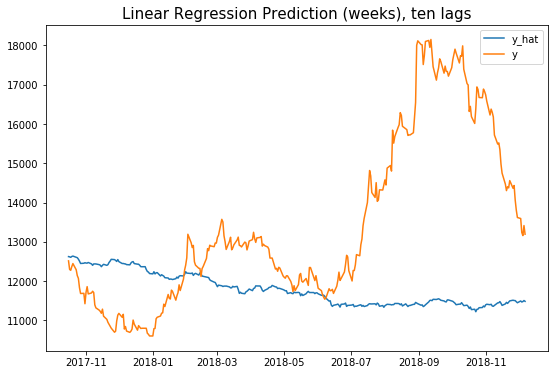

Mean Absolute Error: 2175.1055804799266
Mean Squared Error: 8777081.982772386
Root Mean Squared Error: 2962.614045530127


In [29]:
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']


In [21]:
original_y_train = LME_shifted.loc[:'2017-10-14']
plt.plot(y_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

         
         
print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))




Mean Absolute Error: 1639.9856870092333
Mean Squared Error: 3821687.1501097726
Root Mean Squared Error: 1954.9135914688845


In [55]:
original_y_train

NameError: name 'original_y_train' is not defined

# Other Kinds of Regression

Grid Search for RIDGE Regression


{'alpha': 1e-05}
Mean Absolute Error: 2175.105580476471
Mean Squared Error: 8777081.982747449
Root Mean Squared Error: 2962.6140455259183

{'alpha': 0.0001}
Mean Absolute Error: 2175.1055804449356
Mean Squared Error: 8777081.982522247
Root Mean Squared Error: 2962.6140454879114

{'alpha': 0.001}
Mean Absolute Error: 2175.1055801312123
Mean Squared Error: 8777081.980287297
Root Mean Squared Error: 2962.614045110719

{'alpha': 0.01}
Mean Absolute Error: 2175.105577075356
Mean Squared Error: 8777081.958260499
Root Mean Squared Error: 2962.614041393259

{'alpha': 0.1}
Mean Absolute Error: 2175.105546818765
Mean Squared Error: 8777081.73943206
Root Mean Squared Error: 2962.6140044616104

{'alpha': 1}
Mean Absolute Error: 2175.1052472473866
Mean Squared Error: 8777079.561684202
Root Mean Squared Error: 2962.6136369233504

Ridge CV Results
{'alpha': 1e-05} 2175.105580476471
{'alpha': 0.0001} 2175.1055804449356
{'alpha': 0.001} 2175.1055801312123
{'alpha': 0.01} 2175.105577075356
{'alpha': 0.

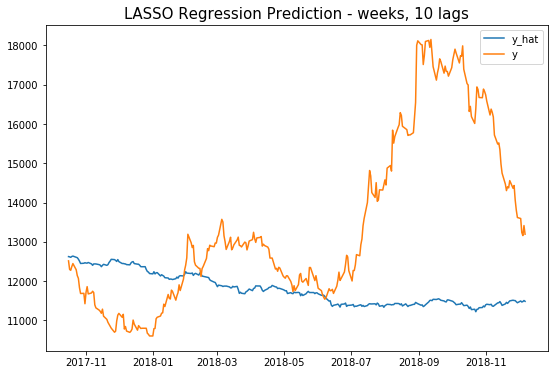

In [30]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


K:  1
Mean Absolute Error: 2082.5986242845233
Mean Squared Error: 6946846.614320247
Root Mean Squared Error: 2635.6871237535474

K:  3
Mean Absolute Error: 1279.0153505891099
Mean Squared Error: 2603086.5816827235
Root Mean Squared Error: 1613.4083741206762

K:  5
Mean Absolute Error: 1306.2842123874589
Mean Squared Error: 2721631.300503557
Root Mean Squared Error: 1649.7367367260624

K:  7
Mean Absolute Error: 1304.9255830160396
Mean Squared Error: 2741760.3989605913
Root Mean Squared Error: 1655.8261982951567

K:  9
Mean Absolute Error: 1241.7080392308753
Mean Squared Error: 2392789.898298187
Root Mean Squared Error: 1546.8645377983771

K:  11
Mean Absolute Error: 1196.6073290166712
Mean Squared Error: 2140226.9574065213
Root Mean Squared Error: 1462.9514542207207

K:  13
Mean Absolute Error: 1195.7021621421186
Mean Squared Error: 2117158.34626852
Root Mean Squared Error: 1455.045822738418

K:  15
Mean Absolute Error: 1181.0221274092653
Mean Squared Error: 2038158.1266007586
Root Me

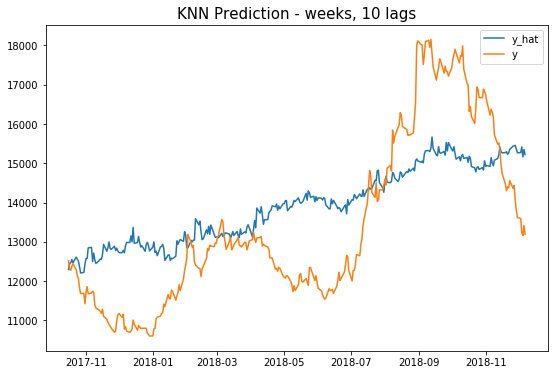

{'1': 2082.5986242845233, '3': 1279.0153505891099, '5': 1306.2842123874589, '7': 1304.9255830160396, '9': 1241.7080392308753, '11': 1196.6073290166712, '13': 1195.7021621421186, '15': 1181.0221274092653, '17': 1189.8106442842618, '19': 1226.4356102803615, '21': 1284.342963832341, '23': 1290.0865851363242, '25': 1310.84700711441, '27': 1355.8106312970194, '29': 1378.4868429350504, '31': 1397.5587771301937, '33': 1370.7968539045871, '35': 1371.6527038949855, '37': 1381.1119076389143, '39': 1373.6865258806495, '41': 1374.4850679704068, '43': 1375.952766831557, '45': 1390.9775351872304, '47': 1386.8930878710812, '49': 1374.9374662581563, '51': 1373.298494769225, '53': 1377.0089088425718, '55': 1368.26042645664, '57': 1361.17931751877, '59': 1346.0678262126496, '61': 1353.059368985342, '63': 1359.508425044782, '65': 1354.0443313797193, '67': 1353.9690234231805}


In [12]:
from sklearn import neighbors

LME_shifted = LME.shift(-261).dropna()


cv_results = {}

for K in range(0,67,2):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

In [51]:
from sklearn import neighbors

LME_shifted = LME.shift(-261).dropna()


cv_results = {}

K = 15
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

print()
print('K: ', K)

regressor.fit(X_train, y_train)
#print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index


print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
#cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)


K:  15
Mean Absolute Error: 1143.4697609804807
Mean Squared Error: 1946995.881932293
Root Mean Squared Error: 1395.3479429634363


{}


MAE for scaled results:  24.315521266944906

Mean Absolute Error: 1381.8860284394898
Mean Squared Error: 2667030.693626002
Root Mean Squared Error: 1633.1046180897297
Polynomial MAE of Degree = 3:  1381.8860284394898


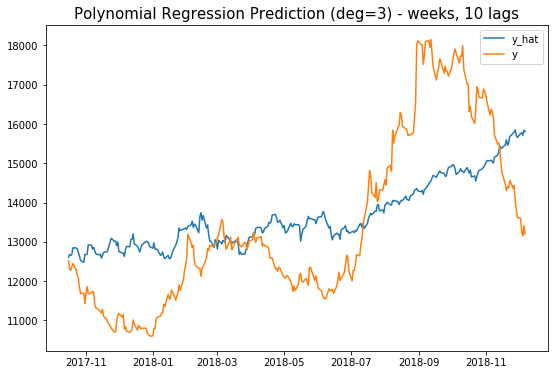

In [12]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index




print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 3: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression Prediction (deg=3) - weeks, 10 lags', fontsize=15)

plt.show()


In [18]:
X_test

lag0      lag1      lag2       lag3      lag4     lag5  \
ds                                                                        
2017-10-16  1061.8000 -873.4375  -465.025  1099.0875   892.950  616.300   
2017-10-17   926.7250 -550.9875  -554.550   833.9375   916.075  777.350   
2017-10-18   778.5750 -487.1125  -299.350   844.5125  1088.650  828.125   
2017-10-19   854.2750 -482.1125  -664.025   759.5375  1090.550  970.725   
2017-10-20   812.0250 -333.2000 -1214.600   139.8750   747.475  559.650   
...               ...       ...       ...        ...       ...      ...   
2018-12-03    -5.2375 -575.6750  -543.325  -107.1500   -34.025  212.900   
2018-12-04   -79.4375 -589.7000  -478.325  -243.3250   394.900  233.100   
2018-12-05    27.0125 -602.0250  -372.650  -363.8250    26.375  140.625   
2018-12-06  -319.1125 -591.7750  -363.125  -403.8250    20.825  -82.700   
2018-12-07  -207.6375 -586.5375  -631.550  -621.7250    -5.400  -13.400   

                lag6      lag7      lag8      lag9     lag10  
ds                                                            
2017-10-16  463.8875  -50.3500   97.3625 -286.5500  -143.375  
2017-10-17  655.2625   63.8500  339.6875 -261.4750   -93.175  
2017-10-18  657.6375  118.9250  345.6625 -100.6750  -223.625  
2017-10-19  712.1875  112.1000  356.4875 -179.5250  -339.875  
2017-10-20  738.3875  456.2750  429.0625  -69.4500  -249.800  
...              ...       ...       ...       ...       ...  
2018-12-03 -745.9500 -154.0625 -132.4875  -21.4750  -872.900  
2018-12-04 -870.9000  120.3625 -253.6625  185.9250  -985.400  
2018-12-05 -411.1250  -38.2375 -824.9125 -239.8500  -800.750  
2018-12-06 -416.6000 -249.3625 -310.1375 -467.0250 -1002.050  
2018-12-07 -334.9500 -739.5000 -149.1875 -204.9625  -731.250  

[300 rows x 11 columns]

MAE for scaled results:  23.59462350562478

Mean Absolute Error: 1265.1136827027678
Mean Squared Error: 2437128.168238446
Root Mean Squared Error: 1561.1304135908845
Polynomial MAE of Degree = 2:  1265.1136827027678


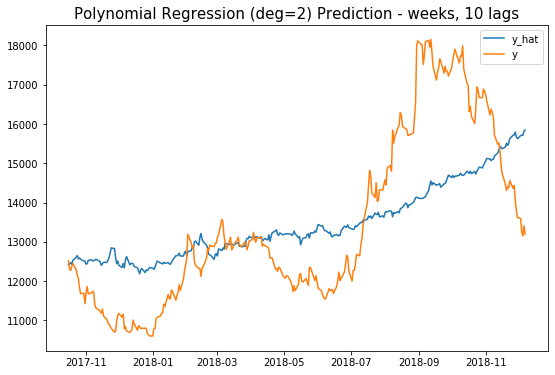

In [13]:
polynomial_features= PolynomialFeatures(degree=2)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index



print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg=2) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


In [14]:
polynomial_features= PolynomialFeatures(degree=4)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index


print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg = 4) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


MAE for scaled results:  26.838576884077373

Mean Absolute Error: 1639.9856870092333
Mean Squared Error: 3821687.1501097726
Root Mean Squared Error: 1954.9135914688845
Polynomial MAE of Degree = 2:  1639.9856870092333
